In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sns.set(style='whitegrid')
sys.path.append('..')

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=RuntimeWarning)

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression, LogisticRegression
from load_data import *

from numpy.random import default_rng
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

<br><br>

# Functions

In [238]:
def extract_part_validation_data(dataframe_validation, create_amount_of_random_numbers = 6, distance_of_max_length = 0, print_differences = True):
    """
    This function takes as input the df_validation and creates for each engine id
    random amount of numbers (create_amount_of_random_numbers). Then it sorts 
    those numbers and takes the lowest and biggest number (e.g. 4 and 142). It
    uses those numbers to slice a random part.
    
    We also can add the parameter 'distance_of_max_length'. This parameter allows
    us to for example set a limit of -50 of the maximum length of an engine id. If
    the engine_id has e.g. length 230 (where the RUL is 0), we can set the limit to
    finding random number between 0 and 180 (instead of 230).
    """
    # Extract all the unique engine ids and their maximum length in the original dataframe
    unique_engine_ids = dataframe_validation.index.unique()
    amount_of_ruls    = {engine_id : dataframe_validation[dataframe_validation.index == engine_id]['cycle'].max()
                         for engine_id in unique_engine_ids}
    
    
    # Loop over all engine ids and their length in the original dataframe_validation
    if print_differences == True:
        print('The validation dataframe includes the following engine ids: {}.\n'.format(list(unique_engine_ids)))
        print('We sliced the validation dataframe into the following slices: \n')
    new_df = pd.DataFrame()
    
    for engine_id, max_length in amount_of_ruls.items():
        random_numbers = np.random.randint(0, (max_length - 1 - distance_of_max_length), create_amount_of_random_numbers)
        random_numbers_sorted = np.sort(random_numbers, axis=None)
        
        if print_differences == True:
            print('Engine Id {} filtered on index : {}.'.format(engine_id, [random_numbers_sorted[0], random_numbers_sorted[-1]]))
            print('This slice has a length of {}.'.format(random_numbers_sorted[-1] - random_numbers_sorted[0]))
            print('The original total length of the engine id was {}.'.format(amount_of_ruls[engine_id]))
            print('------------------------------------------------\n')

        df_filtered = dataframe_validation[dataframe_validation.index == engine_id]
        df_filtered = df_filtered.iloc[random_numbers_sorted[0] : random_numbers_sorted[-1]]
        
        new_df = new_df.append(df_filtered)
        
    return new_df

In [239]:
def create_multiple_slices_of_validation_dataframe(validation_dataframe, total_amount = 5):
    """
    This function takes 'total_amount' of 'random slices' of the validation_dataframe. 
    This allows us to make the validation set bigger.
    """

    def change_indexes_of_dataframe(dataframe, start_from = 0):
        """
        This function resets the indexes.
        """
        # Extract current indexes
        indexes   = dataframe.index.unique()
        
        # Make a dictionary with ({old_index : new_index, ...})
        new_names = dict(zip(indexes, range(start_from, start_from + len(indexes))))    
    
        # Rename the indexes.
        dataframe_renamed_indexes = dataframe.rename(index = new_names)

        return dataframe_renamed_indexes
    
    final_dataframe = pd.DataFrame()
    current_indexes = 0
    
    for amount in range(0, total_amount):
        # Here we change the indexes of a randomly created validation set.
        sliced_validation_dataframe = extract_part_validation_dataframe_data(sliced_validation_dataframe, create_amount_of_random_numbers = 6, print_differences=False)
        sliced_validation_dataframe = change_indexes_of_dataframe(sliced_validation_dataframe, current_indexes)
        
        # Change current_indexes to a new number.
        current_indexes = sliced_validation_dataframe_dataframe.index.unique()[-1] + 1
        
        final_dataframe = final_dataframe.append(sliced_validation_dataframe)
        
    return final_dataframe

In [240]:
def get_ruls(dataframe):
    """
    Get the ruls of the engines
    """
    # Try to drop max cycle to prevent an error
    dataframe = dataframe.drop('max_cycle', 1, errors='ignore')
    
    # The max cycle of each engine
    max_cycle = dataframe.groupby('engine_id').agg({'cycle': 'max'}).rename({'cycle': 'max_cycle'}, axis=1)
    
    # Add the max cycle to the dataframe
    dataframe = dataframe.join(max_cycle, on='engine_id', )
    
    # Ruls are max cycle minus current cycle (plus 1)
    ruls = (dataframe['max_cycle'] - dataframe['cycle'] + 1).values
    
    return ruls

In [241]:
def load_add_rul_filter_and_norm_data(percentage_validation_set, path = '../data/DataTrain.txt'):
    df = load_dataset(path)
    df = df.set_index('engine_id')
    
    # Based on the analysing the slopes we found that the following sensors had
    # showed a trend and had the highest average slope. We focus on the sensors 
    # with higher slopes because this makes it easier to distinguish the different RULs.
    df = df[['cycle', 's4', 's3', 's17', 's7', 's12', 's2']]
    df.loc[:, 'rul'] = get_ruls(df)
    
    # Calculate percentage validation set
    unique_engine_ids = df.index.unique()
    
    engine_ids_for_validation_set = default_rng().choice(unique_engine_ids,
                                                   size = int(max(unique_engine_ids) * percentage_validation_set), 
                                                   replace=False)
    
    # Split data into df_train and df_validation
    df_train       = df[~df.index.isin(engine_ids_for_validation_set)]
    df_validation  = df[df.index.isin(engine_ids_for_validation_set)]
    
    # Normalize both dataframes
    scaler = StandardScaler()
    df_train.iloc[:, 1:-1]       = scaler.fit_transform(df_train.iloc[:, 1:-1])
    df_validation.iloc[:, 1:-1]  = scaler.transform(df_validation.iloc[:, 1:-1])
    
    return df_train, df_validation

In [383]:
def prepare_k_fold_train_validation_set(k_folds, path = '../data/DataTrain.txt'):
    """
    This function creates k_folds of train and validation sets.
    """
    df = load_dataset(path)
    df = df.set_index('engine_id')
    
    # Based on the analysing the slopes we found that the following sensors had
    # showed a trend and had the highest average slope. We focus on the sensors 
    # with higher slopes because this makes it easier to distinguish the different RULs.
    df = df[['cycle', 's4', 's3', 's17', 's7', 's12', 's2']]
    df.loc[:, 'rul'] = get_ruls(df)
    
    # Calculate percentage validation set
    unique_engine_ids = df.index.unique()
    
    # Create k_folds 
    created_k_folds = {}
    begin_index = 0
    length_fold = len(df.index.unique()) // k_folds
    
    for fold in range(0, k_folds):
        end_index = begin_index + length_fold
        get_slice = df.index.unique()[begin_index : end_index]
        
        # Extract rows
        df_training   = df[~df.index.isin(get_slice)]
        df_validation = df.loc[get_slice]
        
        # Apply scaler
        scaler = StandardScaler()
        df_training.iloc[:, 1:-1]       = scaler.fit_transform(df_training.iloc[:, 1:-1])
        df_validation.iloc[:, 1:-1]  = scaler.transform(df_validation.iloc[:, 1:-1])
        
        created_k_folds[fold] = {'training'   : df_training, 
                                 'validation' : df_validation}
        
        begin_index += length_fold
        
    # Return the k_folds as a dictionary
    return created_k_folds

In [242]:
def slopes_all_engine(training_dataframe):
    """
    Get the sensor slopes of all engines.
    """
    def get_training_data(dataframe, engine_id, sensor_cols):
        # X data
        X = dataframe.loc[engine_id, 'rul'].values
        X = X.reshape(-1, 1)

        # y data
        y = dataframe.loc[engine_id, sensor_cols].values

        return (X, y)
    
    def slopes_of_engine(X, y):
        """
        Fit a linear model on the sensor values of one engine
        """
        # Create a linear model
        linear_model = LinearRegression()

        # Fit the model
        linear_model.fit(X, y)

        # Get slopes
        slopes = linear_model.coef_[:,0]

        return slopes
    
    # Loop over all the engines and calculate the slopes.
    engine_slopes = {}
    sensor_cols = training_dataframe.columns[1: -1].tolist()
    
    for engine_id in training_dataframe.index.unique():
        X, y = get_training_data(training_dataframe, engine_id, sensor_cols)
        slopes = slopes_of_engine(X, y)
        
        engine_slopes[engine_id] = slopes
        
    df_engine_slopes = pd.DataFrame(engine_slopes).T

    df_engine_slopes.columns = sensor_cols
    df_engine_slopes.index.name = 'engine_id'

    return df_engine_slopes

In [243]:
def perform_pca(dataframe_with_engine_slopes, dataframe_training, dataframe_validation, 
                n_components = 3, keep_rul_in_validation = True):
    """
    Here we will perform the PCA on the training and validation set.
    """
    # Fit the PCA on the engine slopes to reduce the dimensionality.
    pca = PCA(n_components=n_components)
    pca.fit(dataframe_with_engine_slopes)
        
    # Apply PCA on the dataframes    
    matrix_training = np.column_stack([dataframe_training[['cycle', 'rul']].values, pca.transform(dataframe_training.iloc[:, 1:-1])])   
    df_pca_training = pd.DataFrame(matrix_training, index=dataframe_training.index, columns=['cycle', 'rul', 'pca1', 'pca2', 'pca3'])
        
    if keep_rul_in_validation == True:
        matrix_validation  = np.column_stack([dataframe_validation[['cycle', 'rul']].values, pca.transform(dataframe_validation.iloc[:, 1:-1])])
        df_pca_validation  = pd.DataFrame(matrix_validation, index=dataframe_validation.index, columns=['cycle', 'rul', 'pca1', 'pca2', 'pca3'])

    else: 
        matrix_validation  = np.column_stack([dataframe_validation[['cycle']].values, pca.transform(dataframe_validation.iloc[:, 1:])])
        df_pca_validation  = pd.DataFrame(matrix_validation, index=dataframe_validation.index, columns=['cycle', 'pca1', 'pca2', 'pca3'])

    return df_pca_training, df_pca_validation

In [244]:
def train_health_indictor_model(dataframe_training_with_pca_values, high_rul = 250, low_rul = 5):
    """
    This function applies sensor fusing to the training data and returns a
    trained model to make predictions.
    """
    # Extract ruls
    ruls     = dataframe_training_with_pca_values['rul'].values
    
    # Extract rows
    idx_high_health = [ruls > high_rul][0]
    idx_low_health  = [ruls <= low_rul][0]
    
    # PCA to perform sensor fusing on
    high_health_data = dataframe_training_with_pca_values.loc[idx_high_health, ['pca1', 'pca2', 'pca3']]
    low_health_data  = dataframe_training_with_pca_values.loc[idx_low_health, ['pca1', 'pca2', 'pca3']]
    
    # concatenate high HI and Low HI data
    X_health = np.concatenate((high_health_data, low_health_data),axis=0)

    # target for the fused signal [ just 0 or 1 for failed ans healthy]
    y_one = np.ones(high_health_data.shape[0])
    y_zero = np.zeros(low_health_data.shape[0])

    # concatenate high HI and Low HI target
    y_health = np.concatenate((y_one, y_zero),axis=0)
    
    # Linear regression
    linear_model = LinearRegression()
    linear_model.fit(X_health, y_health)
    
    return linear_model

In [245]:
def add_exponential_fits(dataframe_with_health_index):
    def exp_func(x, a, b):
        return a * (np.exp(b * -x)-1)

    def find_exp_params(dataframe):
        exp_params = np.zeros((dataframe.index.nunique(), 2))

        # Loop through the engines
        for idx, (engine_id, engine) in enumerate(dataframe.groupby('engine_id')):
            x = engine['rul']
            y = savgol_filter(engine['hi_pred'], 25, 1)

            popt, _ = curve_fit(exp_func, x, y)

            exp_params[idx, :] = popt

        return exp_params

    def get_exponential(timestep, row):
        return exp_func(timestep['rul'], *exp_params[row, :])

    exp_params = find_exp_params(dataframe_with_health_index)

    dataframe_with_health_index['exp'] = 0

    for index, engine_id in enumerate(dataframe_with_health_index.index.unique()):
        indexes = dataframe_with_health_index[dataframe_with_health_index.index == engine_id].index
        dataframe_with_health_index.loc[indexes, 'exp'] = dataframe_with_health_index.loc[indexes].apply(lambda x: get_exponential(x, index), axis =1)
    
    return dataframe_with_health_index

In [246]:
def predict_rul_based_on_weighted_ssd(list_with_ssd_and_rul, extract_best_x = 5):
    """
    This function makes based on a nested list [(ssd1, rul1), ... , (ssdN, rulN)]
    a weighted prediction based on the ssd.
    """
    
    # Create a dataframe of the nested list
    df_ssd_and_rul = pd.DataFrame(list_with_ssd_and_rul, columns=['ssd', 'rul'])
        
    # Sort the dataframe based on the ssd and extract top X (extract_best_x)
    df_ssd_and_rul = df_ssd_and_rul.sort_values('ssd').iloc[ : extract_best_x]
    
    # Add percentage ssd of total
    sum_ssd = sum(1 / df_ssd_and_rul['ssd'].values)   
    df_ssd_and_rul['percentage_of_total'] = (1 / df_ssd_and_rul['ssd']) / sum_ssd
    
    # Make weighted predictions
    weighted_prediction = sum(df_ssd_and_rul['rul'] * df_ssd_and_rul['percentage_of_total'])
    
    # Return prediction
    return weighted_prediction

In [406]:
def find_for_engineid_lowest_loss(dataframe_training, 
                                  dataframe_validation_engineid,
                                  make_prediction_only = False,
                                  print_differences = True):
    
    results = list()
    length    = len(dataframe_validation_engineid)
    
    # We will look in each engine (of dataframe_training) for the lowest loss.
    # When we find it, we will store it with the predicted RUL. This allows us 
    # to make predictions taking into account all the engineids.
    for engine_id in dataframe_training.index.unique():
        filtered_df = dataframe_training[dataframe_training.index == engine_id]
        best_loss   = np.inf
        best_train_slice = list()
        
        # Loop over each array in the filtered dataframe and try to find the 
        # best 'exp' where the loss is the lowest.
        for row_index in range(0, len(filtered_df) - length):
            train_slice             = filtered_df.iloc[row_index : (row_index+length)]
            train_health_index      = train_slice['exp'].values
            validation_health_index = dataframe_validation_engineid['hi_pred'].values

            loss = np.sum((train_health_index - validation_health_index) ** 2)

            if loss < best_loss:
                best_loss        = loss
                best_train_slice = train_slice
                
        # If we couldn't find any good fit on the 'exp' in this engine id, skip the
        # appending to the results.
        if best_loss == np.inf:
            continue
            
        # Add the result (loss and the RUL)
        results.append([best_loss, int(best_train_slice.iloc[-1]['rul'])])
        
    # Make a weighted prediction based on the nested list
    weighted_prediction = int(predict_rul_based_on_weighted_ssd(results))
    
    if make_prediction_only == False:
        best_rul_difference = abs(int(dataframe_validation_engineid.iloc[-1]['rul']) - weighted_prediction)
        
        if print_differences == True:
            print('Best loss:      ', best_loss)
            print('Train RUL:      ', int(weighted_prediction))
            print('Validation RUL: ', int(dataframe_validation_engineid.iloc[-1]['rul']))
            print('RUL difference: ', best_rul_difference)
            print('\n')    

        return weighted_prediction, int(dataframe_validation_engineid.iloc[-1]['rul'])
    
    else:
        return weighted_prediction

In [248]:
def final_prediction(dataframe_training, dataframe_schedule):
    """
    This function makes a prediction on the dataframe_schedule using the
    dataframe_training.
    
    To make a prediction, we apply the following steps:
    1. Extract the relevant columns from both tables.
    2. Calculate the slopes of the dataframe_training.
    3. Apply PCA and transform both dataframe_training and dataframe_schedule.
    4. Train a linear model to predict the health indicators.
    5. Predict the health indicators (hi_pred) of both tables.
    6. Add fit an exponential model on the hi_pred of dataframe_training (exp).
    7. Try to fit each engine_ids hi_pred in the dataframe_schedule on the best
       suiting 'exp'. Based on the best fit we will predict the RUL.
    """
    # Extract the relevant columns from both tables
    columns = ['cycle', 's4', 's3', 's17', 's7', 's12', 's2', 'rul']
    
    dataframe_training = dataframe_training[columns]
    dataframe_schedule = dataframe_schedule[columns[: -1]]
            
    # Calculate slopes of the dataframe_training
    dataframe_training_slopes = slopes_all_engine(dataframe_training)
    
    # Reduce dimensionalities with PCA
    dataframe_training_pca, dataframe_schedule_pca = perform_pca(dataframe_training_slopes, 
                                                                 dataframe_training, 
                                                                 dataframe_schedule, 
                                                                 keep_rul_in_validation = False)
    
    # Train linear model
    trained_model = train_health_indictor_model(dataframe_training_pca)
        
    # Predict health indicator
    dataframe_training['hi_pred'] = trained_model.predict(dataframe_training_pca[['pca1', 'pca2', 'pca3']])
    dataframe_schedule['hi_pred'] = trained_model.predict(dataframe_schedule_pca[['pca1', 'pca2', 'pca3']])
    
    # Add exponential fit
    dataframe_training = add_exponential_fits(dataframe_training)
    
    # Make predictions
    results = {}
    
    for engineid in dataframe_training.index.unique():
        results[engineid] = find_for_engineid_lowest_loss(dataframe_training, 
                                                          dataframe_schedule[dataframe_schedule.index == engineid],
                                                          make_prediction_only = True)    
        
    return results

In [420]:
def plot_k_fold_result(cross_validation_results):
    for foldnr, fold in cross_validation_results.items():
        validation_pred = fold['validation_pred']
        y_validation    = fold['y_validation']
    
        # Plot results
        fig, ax = plt.subplots()
        ax.scatter(validation_pred, y_validation, edgecolors=(0, 0, 0))
        ax.plot([min(y_validation), max(y_validation)], [min(y_validation), max(y_validation)], 'k--')
        ax.set_xlabel('Predicted RUL')
        ax.set_ylabel('Actual RUL')
        ax.set_title('K_Fold {} Predicted RUL vs Actual RUL'.format(foldnr + 1))
        plt.show();

<br><br><br><br><br>

# Boosted validation set

In [407]:
import time
import sys

In [405]:
%%time

# Cross validation results
cv_results = {}

# Create k_folds of train and validation set.
k_folds = prepare_k_fold_train_validation_set(k_folds = 5)

# Loop over each fold and check results
for foldnr, fold_values in k_folds.items():    
    # Keep track of the time
    start = time.time()
    print('Started with foldnr {} (start time {}).'.format(foldnr, start))
    
    
    # Extract training and validation set
    df_training   = fold_values['training']
    df_validation = fold_values['validation']
    
    # Enhance the validation set by taking random slices
    df_validation = create_multiple_slices_of_test_dataframe(df_validation, total_amount = 20)
    
    # Extract slopes
    df_slopes = slopes_all_engine(df_training)
    
    # Reduce the dimensionalities to 3 dimensions
    df_training_pca, df_validation_pca = perform_pca(df_slopes, df_training, df_validation, keep_rul_in_validation = True)

    # Train model to predict Health Indicator
    model = train_health_indictor_model(df_training_pca)

    # Add health indicator
    df_training_pca['hi_pred']   = model.predict(df_training_pca[['pca1', 'pca2', 'pca3']])
    df_validation_pca['hi_pred'] = model.predict(df_validation_pca[['pca1', 'pca2', 'pca3']])
    
    # Add exponential fit
    df_training_with_hi_and_exp = add_exponential_fits(df_training_pca)
    
    print('Finished with exponential fits.')
    
    # Extract predicted RUL and actual RUL
    results = {}
    total_rul_diff = 0

    for engineid in df_validation_pca.index.unique():
        rul_prediction, actual_rul = find_for_engineid_lowest_loss(df_training_with_hi_and_exp, 
                                                       df_validation_pca[df_validation_pca.index == engineid])

        rul_difference = abs(rul_prediction - actual_rul)
        results[engineid] = {'rul_prediction' : rul_prediction,
                             'actual_rul'     : actual_rul,
                             'rul_difference' : rul_difference}
        print('\n\n\nEngine id {} rul difference: {}.\n\n\n'.format(engineid, rul_difference))


        total_rul_diff += rul_difference

    # Get MAE and predicted RUL and actual RUL
    mean_absolute_error = total_rul_diff / len(df_validation_pca.index.unique())
    
    validation_pred  = [element['rul_prediction'] for element in results.values()]
    validation_error = [element['rul_difference'] for element in results.values()]
    y_validation     = [element['actual_rul'] for element in results.values()]
    
    
    # Add the result of the fold
    cv_results[foldnr] = {'validation_pred'  : validation_pred, 
                          'validation_error' : validation_error,
                          'y_validation'     : y_validation,
                          'mean_absolute_error' : mean_absolute_error}
    
    print('Finished with foldnr {} (end time {}).\n\n'.format(foldnr, time.time() - start))

Started with foldnr 0.
Finished with exponential fits.
Best loss:       2.802822341496756
Train RUL:       3
Validation RUL:  3
RUL difference:  0





Engine id 0 rul difference: 0.



Best loss:       6.3828656512268775
Train RUL:       70
Validation RUL:  75
RUL difference:  5





Engine id 1 rul difference: 5.



Best loss:       1.3374026737298237
Train RUL:       11
Validation RUL:  7
RUL difference:  4





Engine id 2 rul difference: 4.



Best loss:       1.5306717247707107
Train RUL:       12
Validation RUL:  7
RUL difference:  5





Engine id 3 rul difference: 5.



Best loss:       inf
Train RUL:       17
Validation RUL:  17
RUL difference:  0





Engine id 4 rul difference: 0.



Best loss:       1.548811053036332
Train RUL:       17
Validation RUL:  22
RUL difference:  5





Engine id 5 rul difference: 5.



Best loss:       inf
Train RUL:       15
Validation RUL:  25
RUL difference:  10





Engine id 6 rul difference: 10.



Best loss:       0.9262981594440223
Train

Best loss:       2.1720799811245284
Train RUL:       10
Validation RUL:  13
RUL difference:  3





Engine id 61 rul difference: 3.



Best loss:       4.201445983085565
Train RUL:       41
Validation RUL:  27
RUL difference:  14





Engine id 62 rul difference: 14.



Best loss:       1.0343307964243047
Train RUL:       29
Validation RUL:  16
RUL difference:  13





Engine id 63 rul difference: 13.



Best loss:       inf
Train RUL:       6
Validation RUL:  7
RUL difference:  1





Engine id 64 rul difference: 1.



Best loss:       1.3443404027473025
Train RUL:       49
Validation RUL:  46
RUL difference:  3





Engine id 65 rul difference: 3.



Best loss:       12.092085019391437
Train RUL:       34
Validation RUL:  49
RUL difference:  15





Engine id 66 rul difference: 15.



Best loss:       0.7723017661417193
Train RUL:       89
Validation RUL:  74
RUL difference:  15





Engine id 67 rul difference: 15.



Best loss:       1.2806743114483161
Train RUL:       74
Validatio

Best loss:       0.8571981039872257
Train RUL:       87
Validation RUL:  39
RUL difference:  48





Engine id 123 rul difference: 48.



Best loss:       inf
Train RUL:       15
Validation RUL:  13
RUL difference:  2





Engine id 124 rul difference: 2.



Best loss:       1.7525550374113856
Train RUL:       10
Validation RUL:  12
RUL difference:  2





Engine id 125 rul difference: 2.



Best loss:       2.5623447342637258
Train RUL:       1
Validation RUL:  5
RUL difference:  4





Engine id 126 rul difference: 4.



Best loss:       0.38333402769115255
Train RUL:       60
Validation RUL:  62
RUL difference:  2





Engine id 127 rul difference: 2.



Best loss:       9.313804342382621
Train RUL:       39
Validation RUL:  21
RUL difference:  18





Engine id 128 rul difference: 18.



Best loss:       10.512966104491419
Train RUL:       52
Validation RUL:  58
RUL difference:  6





Engine id 129 rul difference: 6.



Best loss:       2.58546866706359
Train RUL:       68
Validat

Best loss:       3.7564666974561307
Train RUL:       3
Validation RUL:  4
RUL difference:  1





Engine id 184 rul difference: 1.



Best loss:       1.8346644120614006
Train RUL:       8
Validation RUL:  10
RUL difference:  2





Engine id 185 rul difference: 2.



Best loss:       0.9025174139952328
Train RUL:       32
Validation RUL:  42
RUL difference:  10





Engine id 186 rul difference: 10.



Best loss:       1.564673018645022
Train RUL:       13
Validation RUL:  12
RUL difference:  1





Engine id 187 rul difference: 1.



Best loss:       3.327169566577739
Train RUL:       48
Validation RUL:  22
RUL difference:  26





Engine id 188 rul difference: 26.



Best loss:       9.352871451142814
Train RUL:       47
Validation RUL:  56
RUL difference:  9





Engine id 189 rul difference: 9.



Best loss:       inf
Train RUL:       18
Validation RUL:  12
RUL difference:  6





Engine id 190 rul difference: 6.



Best loss:       1.1291568673370502
Train RUL:       29
Validatio

Best loss:       2.7104202955398846
Train RUL:       3
Validation RUL:  4
RUL difference:  1





Engine id 245 rul difference: 1.



Best loss:       5.397417355561551
Train RUL:       16
Validation RUL:  25
RUL difference:  9





Engine id 246 rul difference: 9.



Best loss:       0.8083881816200856
Train RUL:       51
Validation RUL:  37
RUL difference:  14





Engine id 247 rul difference: 14.



Best loss:       7.746069614707729
Train RUL:       15
Validation RUL:  7
RUL difference:  8





Engine id 248 rul difference: 8.



Best loss:       inf
Train RUL:       15
Validation RUL:  14
RUL difference:  1





Engine id 249 rul difference: 1.



Best loss:       2.242214594524242
Train RUL:       12
Validation RUL:  10
RUL difference:  2





Engine id 250 rul difference: 2.



Best loss:       0.5475241640074201
Train RUL:       9
Validation RUL:  11
RUL difference:  2





Engine id 251 rul difference: 2.



Best loss:       0.6587086326131817
Train RUL:       20
Validation R

Best loss:       1.1145929728380077
Train RUL:       7
Validation RUL:  7
RUL difference:  0





Engine id 307 rul difference: 0.



Best loss:       9.79724790108905
Train RUL:       57
Validation RUL:  31
RUL difference:  26





Engine id 308 rul difference: 26.



Best loss:       inf
Train RUL:       6
Validation RUL:  3
RUL difference:  3





Engine id 309 rul difference: 3.



Best loss:       inf
Train RUL:       33
Validation RUL:  30
RUL difference:  3





Engine id 310 rul difference: 3.



Best loss:       1.001255471567566
Train RUL:       25
Validation RUL:  28
RUL difference:  3





Engine id 311 rul difference: 3.



Best loss:       0.2722987517478666
Train RUL:       20
Validation RUL:  14
RUL difference:  6





Engine id 312 rul difference: 6.



Best loss:       1.181961946468682
Train RUL:       8
Validation RUL:  6
RUL difference:  2





Engine id 313 rul difference: 2.



Best loss:       9.994627019704916
Train RUL:       15
Validation RUL:  16
RUL differe

Best loss:       9.633009995211724
Train RUL:       40
Validation RUL:  48
RUL difference:  8





Engine id 369 rul difference: 8.



Best loss:       7.112224084697023
Train RUL:       16
Validation RUL:  13
RUL difference:  3





Engine id 370 rul difference: 3.



Best loss:       0.8150377902253958
Train RUL:       24
Validation RUL:  24
RUL difference:  0





Engine id 371 rul difference: 0.



Best loss:       0.6821814836851094
Train RUL:       18
Validation RUL:  13
RUL difference:  5





Engine id 372 rul difference: 5.



Best loss:       1.100406339685615
Train RUL:       26
Validation RUL:  21
RUL difference:  5





Engine id 373 rul difference: 5.



Best loss:       8.092927167000566
Train RUL:       6
Validation RUL:  8
RUL difference:  2





Engine id 374 rul difference: 2.



Best loss:       2.133303981589244
Train RUL:       50
Validation RUL:  63
RUL difference:  13





Engine id 375 rul difference: 13.



Best loss:       5.4911412861403335
Train RUL:       

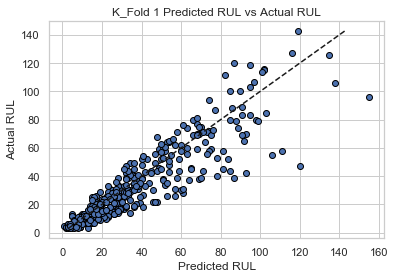

In [419]:
plot_k_fold_result(cv_results)

In [ ]:
%%time
results = {}
total_rul_diff = 0

for engineid in df_validation_pca.index.unique():
    rul_prediction, actual_rul = find_for_engineid_lowest_loss(df_training_with_hi_and_exp, 
                                                   df_validation_pca[df_validation_pca.index == engineid])
    
    rul_difference = abs(rul_prediction - actual_rul)
    results[engineid] = {'rul_prediction' : rul_prediction,
                         'actual_rul'     : actual_rul,
                         'rul_difference' : rul_difference}
    print('\n\n\nEngine id {} rul difference: {}.\n\n\n'.format(engineid, rul_difference))
    
    
    total_rul_diff += rul_difference
    
total_rul_diff

In [396]:
results

{0: {'rul_prediction': 86, 'actual_rul': 77, 'rul_difference': 9},
 1: {'rul_prediction': 40, 'actual_rul': 37, 'rul_difference': 3},
 2: {'rul_prediction': 11, 'actual_rul': 5, 'rul_difference': 6},
 3: {'rul_prediction': 24, 'actual_rul': 22, 'rul_difference': 2},
 4: {'rul_prediction': 92, 'actual_rul': 94, 'rul_difference': 2},
 5: {'rul_prediction': 49, 'actual_rul': 43, 'rul_difference': 6},
 6: {'rul_prediction': 65, 'actual_rul': 63, 'rul_difference': 2},
 7: {'rul_prediction': 7, 'actual_rul': 3, 'rul_difference': 4},
 8: {'rul_prediction': 27, 'actual_rul': 21, 'rul_difference': 6},
 9: {'rul_prediction': 30, 'actual_rul': 36, 'rul_difference': 6},
 10: {'rul_prediction': 5, 'actual_rul': 3, 'rul_difference': 2},
 11: {'rul_prediction': 14, 'actual_rul': 9, 'rul_difference': 5},
 12: {'rul_prediction': 27, 'actual_rul': 24, 'rul_difference': 3},
 13: {'rul_prediction': 19, 'actual_rul': 30, 'rul_difference': 11},
 14: {'rul_prediction': 22, 'actual_rul': 17, 'rul_difference':

In [220]:
%%time

# Create split
df_training, df_validation = load_add_rul_filter_and_norm_data(percentage_validation_set=0.2)

# Extract random slice of dataframe
df_validation = create_multiple_slices_of_test_dataframe(df_validation, total_amount = 100)

# Extract slopes
df_slopes = slopes_all_engine(df_training)

# Reduce the dimensionalities to 3 dimensions
df_training_pca, df_validation_pca = perform_pca(df_slopes, df_training, df_validation, keep_rul_in_validation = True)

# Train model to predict Health Indicator
gekke_model = train_health_indictor_model(df_training_pca)

# Add health indicator
df_training_pca['hi_pred']   = gekke_model.predict(df_training_pca[['pca1', 'pca2', 'pca3']])
df_validation_pca['hi_pred'] = gekke_model.predict(df_validation_pca[['pca1', 'pca2', 'pca3']])

Wall time: 8.37 s


In [221]:
%%time
df_training_with_hi_and_exp = add_exponential_fits(df_training_pca)

Wall time: 1min 36s


In [222]:
%%time
results = {}
total_rul_diff = 0

for engineid in df_validation_pca.index.unique():
    rul_prediction, actual_rul = find_for_engineid_lowest_loss(df_training_with_hi_and_exp, 
                                                   df_validation_pca[df_validation_pca.index == engineid])
    
    rul_difference = abs(rul_prediction - actual_rul)
    results[engineid] = {'rul_prediction' : rul_prediction,
                         'actual_rul'     : actual_rul,
                         'rul_difference' : rul_difference}
    print('\n\n\nEngine id {} rul difference: {}.\n\n\n'.format(engineid, rul_difference))
    
    
    total_rul_diff += rul_difference
    
total_rul_diff

Best loss:       5.976903740746523
Train RUL:       86
Test RUL:        77
RUL difference:  9





Engine id 0 rul difference: 9.



Best loss:       1.4860550933680081
Train RUL:       40
Test RUL:        37
RUL difference:  3





Engine id 1 rul difference: 3.



Best loss:       0.935115794905552
Train RUL:       11
Test RUL:        5
RUL difference:  6





Engine id 2 rul difference: 6.



Best loss:       1.232192614201935
Train RUL:       24
Test RUL:        22
RUL difference:  2





Engine id 3 rul difference: 2.



Best loss:       0.25170894874785177
Train RUL:       92
Test RUL:        94
RUL difference:  2





Engine id 4 rul difference: 2.



Best loss:       1.2996944865981397
Train RUL:       49
Test RUL:        43
RUL difference:  6





Engine id 5 rul difference: 6.



Best loss:       1.1190849717032658
Train RUL:       65
Test RUL:        63
RUL difference:  2





Engine id 6 rul difference: 2.



Best loss:       1.314673323452984
Train RUL:       7
Test RUL:  

Best loss:       0.33848952227183465
Train RUL:       91
Test RUL:        73
RUL difference:  18





Engine id 62 rul difference: 18.



Best loss:       0.28901119683603954
Train RUL:       2
Test RUL:        5
RUL difference:  3





Engine id 63 rul difference: 3.



Best loss:       0.7396561504710163
Train RUL:       12
Test RUL:        12
RUL difference:  0





Engine id 64 rul difference: 0.



Best loss:       1.134575719116625
Train RUL:       83
Test RUL:        64
RUL difference:  19





Engine id 65 rul difference: 19.



Best loss:       2.6114956839388155
Train RUL:       46
Test RUL:        35
RUL difference:  11





Engine id 66 rul difference: 11.



Best loss:       0.29984879065759185
Train RUL:       57
Test RUL:        54
RUL difference:  3





Engine id 67 rul difference: 3.



Best loss:       0.8401310692003264
Train RUL:       25
Test RUL:        24
RUL difference:  1





Engine id 68 rul difference: 1.



Best loss:       inf
Train RUL:       8
Test RUL:

Best loss:       0.5092170003710642
Train RUL:       45
Test RUL:        44
RUL difference:  1





Engine id 124 rul difference: 1.



Best loss:       0.7242923770314069
Train RUL:       101
Test RUL:        75
RUL difference:  26





Engine id 125 rul difference: 26.



Best loss:       2.0416782317460376
Train RUL:       44
Test RUL:        41
RUL difference:  3





Engine id 126 rul difference: 3.



Best loss:       0.6961987784181568
Train RUL:       84
Test RUL:        78
RUL difference:  6





Engine id 127 rul difference: 6.



Best loss:       0.8819680579494606
Train RUL:       25
Test RUL:        23
RUL difference:  2





Engine id 128 rul difference: 2.



Best loss:       inf
Train RUL:       9
Test RUL:        7
RUL difference:  2





Engine id 129 rul difference: 2.



Best loss:       0.3019744407138458
Train RUL:       101
Test RUL:        66
RUL difference:  35





Engine id 130 rul difference: 35.



Best loss:       0.9513928107228735
Train RUL:       14
Tes

Best loss:       1.729230376974702
Train RUL:       9
Test RUL:        5
RUL difference:  4





Engine id 185 rul difference: 4.



Best loss:       1.2851413579053776
Train RUL:       77
Test RUL:        74
RUL difference:  3





Engine id 186 rul difference: 3.



Best loss:       0.6406325992251032
Train RUL:       94
Test RUL:        89
RUL difference:  5





Engine id 187 rul difference: 5.



Best loss:       1.3514991709519941
Train RUL:       15
Test RUL:        14
RUL difference:  1





Engine id 188 rul difference: 1.



Best loss:       7.111107593295557
Train RUL:       5
Test RUL:        7
RUL difference:  2





Engine id 189 rul difference: 2.



Best loss:       0.8337723598413859
Train RUL:       8
Test RUL:        9
RUL difference:  1





Engine id 190 rul difference: 1.



Best loss:       0.623105271002329
Train RUL:       52
Test RUL:        47
RUL difference:  5





Engine id 191 rul difference: 5.



Best loss:       3.782994416556974
Train RUL:       15
Te

Best loss:       0.6471507284927934
Train RUL:       78
Test RUL:        75
RUL difference:  3





Engine id 247 rul difference: 3.



Best loss:       0.9279177074737217
Train RUL:       27
Test RUL:        26
RUL difference:  1





Engine id 248 rul difference: 1.



Best loss:       6.706248663581176
Train RUL:       37
Test RUL:        43
RUL difference:  6





Engine id 249 rul difference: 6.



Best loss:       0.3655614372613064
Train RUL:       14
Test RUL:        15
RUL difference:  1





Engine id 250 rul difference: 1.



Best loss:       0.7646317802517583
Train RUL:       76
Test RUL:        60
RUL difference:  16





Engine id 251 rul difference: 16.



Best loss:       3.8715583972195495
Train RUL:       12
Test RUL:        12
RUL difference:  0





Engine id 252 rul difference: 0.



Best loss:       inf
Train RUL:       26
Test RUL:        38
RUL difference:  12





Engine id 253 rul difference: 12.



Best loss:       1.1174432935097687
Train RUL:       4
Test 

Best loss:       16.63460228783267
Train RUL:       68
Test RUL:        59
RUL difference:  9





Engine id 309 rul difference: 9.



Best loss:       0.6431552785094414
Train RUL:       22
Test RUL:        23
RUL difference:  1





Engine id 310 rul difference: 1.



Best loss:       0.8414426185121346
Train RUL:       8
Test RUL:        4
RUL difference:  4





Engine id 311 rul difference: 4.



Best loss:       1.894877838640877
Train RUL:       29
Test RUL:        27
RUL difference:  2





Engine id 312 rul difference: 2.



Best loss:       inf
Train RUL:       30
Test RUL:        35
RUL difference:  5





Engine id 313 rul difference: 5.



Best loss:       0.6828577292701401
Train RUL:       8
Test RUL:        6
RUL difference:  2





Engine id 314 rul difference: 2.



Best loss:       0.4647563913635772
Train RUL:       70
Test RUL:        50
RUL difference:  20





Engine id 315 rul difference: 20.



Best loss:       3.8726912353176637
Train RUL:       20
Test RUL:  

Best loss:       0.9988536667674826
Train RUL:       19
Test RUL:        12
RUL difference:  7





Engine id 371 rul difference: 7.



Best loss:       1.883938820382374
Train RUL:       24
Test RUL:        21
RUL difference:  3





Engine id 372 rul difference: 3.



Best loss:       inf
Train RUL:       60
Test RUL:        80
RUL difference:  20





Engine id 373 rul difference: 20.



Best loss:       0.7595534123875589
Train RUL:       8
Test RUL:        6
RUL difference:  2





Engine id 374 rul difference: 2.



Best loss:       1.1592619362641208
Train RUL:       29
Test RUL:        17
RUL difference:  12





Engine id 375 rul difference: 12.



Best loss:       2.9493748917310496
Train RUL:       20
Test RUL:        19
RUL difference:  1





Engine id 376 rul difference: 1.



Best loss:       2.1268091461333882
Train RUL:       6
Test RUL:        6
RUL difference:  0





Engine id 377 rul difference: 0.



Best loss:       inf
Train RUL:       27
Test RUL:        21
RUL

Best loss:       0.7229009103806358
Train RUL:       24
Test RUL:        18
RUL difference:  6





Engine id 434 rul difference: 6.



Best loss:       0.7279616525470887
Train RUL:       30
Test RUL:        27
RUL difference:  3





Engine id 435 rul difference: 3.



Best loss:       2.7336570361854218
Train RUL:       8
Test RUL:        7
RUL difference:  1





Engine id 436 rul difference: 1.



Best loss:       1.9516850228457192
Train RUL:       11
Test RUL:        11
RUL difference:  0





Engine id 437 rul difference: 0.



Best loss:       inf
Train RUL:       35
Test RUL:        29
RUL difference:  6





Engine id 438 rul difference: 6.



Best loss:       1.0205039784808223
Train RUL:       25
Test RUL:        19
RUL difference:  6





Engine id 439 rul difference: 6.



Best loss:       2.535062105950839
Train RUL:       22
Test RUL:        15
RUL difference:  7





Engine id 440 rul difference: 7.



Best loss:       inf
Train RUL:       21
Test RUL:        14
RUL d

Best loss:       1.5622202744787637
Train RUL:       92
Test RUL:        84
RUL difference:  8





Engine id 496 rul difference: 8.



Best loss:       0.6603368809625201
Train RUL:       62
Test RUL:        49
RUL difference:  13





Engine id 497 rul difference: 13.



Best loss:       inf
Train RUL:       54
Test RUL:        58
RUL difference:  4





Engine id 498 rul difference: 4.



Best loss:       1.1947378957900363
Train RUL:       52
Test RUL:        48
RUL difference:  4





Engine id 499 rul difference: 4.



Best loss:       9.973221776327435
Train RUL:       79
Test RUL:        46
RUL difference:  33





Engine id 500 rul difference: 33.



Best loss:       7.6227902714942415
Train RUL:       54
Test RUL:        46
RUL difference:  8





Engine id 501 rul difference: 8.



Best loss:       0.8014262477747045
Train RUL:       41
Test RUL:        29
RUL difference:  12





Engine id 502 rul difference: 12.



Best loss:       1.3946463208683577
Train RUL:       4
Tes

Best loss:       3.697791447059762
Train RUL:       21
Test RUL:        15
RUL difference:  6





Engine id 557 rul difference: 6.



Best loss:       inf
Train RUL:       9
Test RUL:        4
RUL difference:  5





Engine id 558 rul difference: 5.



Best loss:       1.93258821084432
Train RUL:       3
Test RUL:        5
RUL difference:  2





Engine id 559 rul difference: 2.



Best loss:       3.5289106597071935
Train RUL:       50
Test RUL:        23
RUL difference:  27





Engine id 560 rul difference: 27.



Best loss:       4.927130483747632
Train RUL:       72
Test RUL:        58
RUL difference:  14





Engine id 561 rul difference: 14.



Best loss:       0.6704255826576745
Train RUL:       5
Test RUL:        3
RUL difference:  2





Engine id 562 rul difference: 2.



Best loss:       0.8886958232241425
Train RUL:       35
Test RUL:        28
RUL difference:  7





Engine id 563 rul difference: 7.



Best loss:       0.6258339503985162
Train RUL:       18
Test RUL:    

Best loss:       0.6628750911654111
Train RUL:       64
Test RUL:        79
RUL difference:  15





Engine id 618 rul difference: 15.



Best loss:       1.8104672897638387
Train RUL:       37
Test RUL:        31
RUL difference:  6





Engine id 619 rul difference: 6.



Best loss:       10.827923245613913
Train RUL:       77
Test RUL:        43
RUL difference:  34





Engine id 620 rul difference: 34.



Best loss:       inf
Train RUL:       11
Test RUL:        6
RUL difference:  5





Engine id 621 rul difference: 5.



Best loss:       0.2736400181544293
Train RUL:       19
Test RUL:        14
RUL difference:  5





Engine id 622 rul difference: 5.



Best loss:       0.8058304468710898
Train RUL:       18
Test RUL:        18
RUL difference:  0





Engine id 623 rul difference: 0.



Best loss:       0.34463779323314897
Train RUL:       72
Test RUL:        62
RUL difference:  10





Engine id 624 rul difference: 10.



Best loss:       1.5403763518749083
Train RUL:       52
T

Best loss:       1.5615572802637117
Train RUL:       28
Test RUL:        23
RUL difference:  5





Engine id 679 rul difference: 5.



Best loss:       1.38569588630348
Train RUL:       83
Test RUL:        45
RUL difference:  38





Engine id 680 rul difference: 38.



Best loss:       inf
Train RUL:       10
Test RUL:        4
RUL difference:  6





Engine id 681 rul difference: 6.



Best loss:       0.3503491931081271
Train RUL:       22
Test RUL:        16
RUL difference:  6





Engine id 682 rul difference: 6.



Best loss:       0.4472475655612675
Train RUL:       18
Test RUL:        19
RUL difference:  1





Engine id 683 rul difference: 1.



Best loss:       0.5136968334789348
Train RUL:       29
Test RUL:        25
RUL difference:  4





Engine id 684 rul difference: 4.



Best loss:       1.4220202679196288
Train RUL:       37
Test RUL:        32
RUL difference:  5





Engine id 685 rul difference: 5.



Best loss:       3.0665244378292544
Train RUL:       9
Test RUL:

Best loss:       6.4711851970850836
Train RUL:       75
Test RUL:        77
RUL difference:  2





Engine id 741 rul difference: 2.



Best loss:       0.6564246903540634
Train RUL:       49
Test RUL:        40
RUL difference:  9





Engine id 742 rul difference: 9.



Best loss:       0.922906270161948
Train RUL:       6
Test RUL:        8
RUL difference:  2





Engine id 743 rul difference: 2.



Best loss:       0.6113993960921545
Train RUL:       30
Test RUL:        24
RUL difference:  6





Engine id 744 rul difference: 6.



Best loss:       0.6860203521059182
Train RUL:       7
Test RUL:        5
RUL difference:  2





Engine id 745 rul difference: 2.



Best loss:       2.0887190031589693
Train RUL:       28
Test RUL:        22
RUL difference:  6





Engine id 746 rul difference: 6.



Best loss:       0.4270104858195184
Train RUL:       25
Test RUL:        21
RUL difference:  4





Engine id 747 rul difference: 4.



Best loss:       1.654386602438568
Train RUL:       1

Best loss:       0.4913450741940087
Train RUL:       15
Test RUL:        16
RUL difference:  1





Engine id 803 rul difference: 1.



Best loss:       0.68344476584764
Train RUL:       6
Test RUL:        9
RUL difference:  3





Engine id 804 rul difference: 3.



Best loss:       0.7548443264481659
Train RUL:       104
Test RUL:        82
RUL difference:  22





Engine id 805 rul difference: 22.



Best loss:       2.9518299719206156
Train RUL:       24
Test RUL:        18
RUL difference:  6





Engine id 806 rul difference: 6.



Best loss:       1.2921895255935572
Train RUL:       10
Test RUL:        6
RUL difference:  4





Engine id 807 rul difference: 4.



Best loss:       0.928169452802789
Train RUL:       28
Test RUL:        26
RUL difference:  2





Engine id 808 rul difference: 2.



Best loss:       inf
Train RUL:       6
Test RUL:        7
RUL difference:  1





Engine id 809 rul difference: 1.



Best loss:       0.5398343925183627
Train RUL:       8
Test RUL:    

Best loss:       1.4862234847574365
Train RUL:       32
Test RUL:        26
RUL difference:  6





Engine id 865 rul difference: 6.



Best loss:       2.3408345009469422
Train RUL:       39
Test RUL:        32
RUL difference:  7





Engine id 866 rul difference: 7.



Best loss:       1.0310186183505317
Train RUL:       14
Test RUL:        13
RUL difference:  1





Engine id 867 rul difference: 1.



Best loss:       0.9173603511771175
Train RUL:       26
Test RUL:        21
RUL difference:  5





Engine id 868 rul difference: 5.



Best loss:       7.488694319527998
Train RUL:       22
Test RUL:        27
RUL difference:  5





Engine id 869 rul difference: 5.



Best loss:       0.48089006885965413
Train RUL:       29
Test RUL:        27
RUL difference:  2





Engine id 870 rul difference: 2.



Best loss:       1.0619551262704543
Train RUL:       17
Test RUL:        10
RUL difference:  7





Engine id 871 rul difference: 7.



Best loss:       2.609564635961402
Train RUL:   

Best loss:       0.6189186337931446
Train RUL:       48
Test RUL:        53
RUL difference:  5





Engine id 926 rul difference: 5.



Best loss:       1.2216269206009218
Train RUL:       17
Test RUL:        13
RUL difference:  4





Engine id 927 rul difference: 4.



Best loss:       0.4695055399706771
Train RUL:       63
Test RUL:        52
RUL difference:  11





Engine id 928 rul difference: 11.



Best loss:       11.291589715503159
Train RUL:       22
Test RUL:        26
RUL difference:  4





Engine id 929 rul difference: 4.



Best loss:       0.2845067352362838
Train RUL:       108
Test RUL:        64
RUL difference:  44





Engine id 930 rul difference: 44.



Best loss:       1.0878764117722652
Train RUL:       14
Test RUL:        8
RUL difference:  6





Engine id 931 rul difference: 6.



Best loss:       3.576915901624592
Train RUL:       31
Test RUL:        28
RUL difference:  3





Engine id 932 rul difference: 3.



Best loss:       inf
Train RUL:       31
Test

Best loss:       0.9157995640783417
Train RUL:       50
Test RUL:        50
RUL difference:  0





Engine id 987 rul difference: 0.



Best loss:       0.40674346410567114
Train RUL:       59
Test RUL:        56
RUL difference:  3





Engine id 988 rul difference: 3.



Best loss:       7.268914264785466
Train RUL:       96
Test RUL:        78
RUL difference:  18





Engine id 989 rul difference: 18.



Best loss:       0.41385794453275776
Train RUL:       35
Test RUL:        39
RUL difference:  4





Engine id 990 rul difference: 4.



Best loss:       0.8229178401448409
Train RUL:       9
Test RUL:        5
RUL difference:  4





Engine id 991 rul difference: 4.



Best loss:       2.422066922635103
Train RUL:       73
Test RUL:        50
RUL difference:  23





Engine id 992 rul difference: 23.



Best loss:       3.159815864465646
Train RUL:       100
Test RUL:        116
RUL difference:  16





Engine id 993 rul difference: 16.



Best loss:       0.6665597725441037
Train R

Best loss:       0.6612599038111913
Train RUL:       30
Test RUL:        26
RUL difference:  4





Engine id 1048 rul difference: 4.



Best loss:       6.159698831992253
Train RUL:       40
Test RUL:        46
RUL difference:  6





Engine id 1049 rul difference: 6.



Best loss:       0.28224140177412266
Train RUL:       92
Test RUL:        69
RUL difference:  23





Engine id 1050 rul difference: 23.



Best loss:       0.4014536583371142
Train RUL:       25
Test RUL:        14
RUL difference:  11





Engine id 1051 rul difference: 11.



Best loss:       3.9829241999660416
Train RUL:       15
Test RUL:        15
RUL difference:  0





Engine id 1052 rul difference: 0.



Best loss:       1.761438933642583
Train RUL:       50
Test RUL:        55
RUL difference:  5





Engine id 1053 rul difference: 5.



Best loss:       0.5134995356136485
Train RUL:       11
Test RUL:        9
RUL difference:  2





Engine id 1054 rul difference: 2.



Best loss:       1.5924036960907153
Tra

Best loss:       inf
Train RUL:       9
Test RUL:        7
RUL difference:  2





Engine id 1109 rul difference: 2.



Best loss:       0.7567987835863554
Train RUL:       5
Test RUL:        4
RUL difference:  1





Engine id 1110 rul difference: 1.



Best loss:       0.8301128984917041
Train RUL:       30
Test RUL:        24
RUL difference:  6





Engine id 1111 rul difference: 6.



Best loss:       3.1006079234234103
Train RUL:       2
Test RUL:        3
RUL difference:  1





Engine id 1112 rul difference: 1.



Best loss:       inf
Train RUL:       3
Test RUL:        4
RUL difference:  1





Engine id 1113 rul difference: 1.



Best loss:       1.0812614570582604
Train RUL:       5
Test RUL:        4
RUL difference:  1





Engine id 1114 rul difference: 1.



Best loss:       0.808776513547478
Train RUL:       40
Test RUL:        28
RUL difference:  12





Engine id 1115 rul difference: 12.



Best loss:       3.982362700440934
Train RUL:       7
Test RUL:        6
RUL dif

Best loss:       0.37610124954093743
Train RUL:       6
Test RUL:        8
RUL difference:  2





Engine id 1170 rul difference: 2.



Best loss:       0.7962484034208073
Train RUL:       65
Test RUL:        50
RUL difference:  15





Engine id 1171 rul difference: 15.



Best loss:       1.637010435875138
Train RUL:       30
Test RUL:        28
RUL difference:  2





Engine id 1172 rul difference: 2.



Best loss:       4.361398209170891
Train RUL:       88
Test RUL:        100
RUL difference:  12





Engine id 1173 rul difference: 12.



Best loss:       0.43797617030900604
Train RUL:       55
Test RUL:        43
RUL difference:  12





Engine id 1174 rul difference: 12.



Best loss:       1.1718486441147922
Train RUL:       56
Test RUL:        40
RUL difference:  16





Engine id 1175 rul difference: 16.



Best loss:       2.516412335540817
Train RUL:       35
Test RUL:        36
RUL difference:  1





Engine id 1176 rul difference: 1.



Best loss:       3.804876473830012


Best loss:       0.7343170918208103
Train RUL:       21
Test RUL:        12
RUL difference:  9





Engine id 1231 rul difference: 9.



Best loss:       3.6883851317145777
Train RUL:       25
Test RUL:        22
RUL difference:  3





Engine id 1232 rul difference: 3.



Best loss:       inf
Train RUL:       21
Test RUL:        34
RUL difference:  13





Engine id 1233 rul difference: 13.



Best loss:       0.5330961611235867
Train RUL:       37
Test RUL:        29
RUL difference:  8





Engine id 1234 rul difference: 8.



Best loss:       1.1515206748743698
Train RUL:       37
Test RUL:        24
RUL difference:  13





Engine id 1235 rul difference: 13.



Best loss:       3.6734318639913655
Train RUL:       28
Test RUL:        29
RUL difference:  1





Engine id 1236 rul difference: 1.



Best loss:       3.294379419640655
Train RUL:       34
Test RUL:        26
RUL difference:  8





Engine id 1237 rul difference: 8.



Best loss:       inf
Train RUL:       20
Test RUL:   

Best loss:       2.8185884864802944
Train RUL:       14
Test RUL:        14
RUL difference:  0





Engine id 1292 rul difference: 0.



Best loss:       1.7533197332606587
Train RUL:       16
Test RUL:        20
RUL difference:  4





Engine id 1293 rul difference: 4.



Best loss:       0.7158366382026327
Train RUL:       28
Test RUL:        21
RUL difference:  7





Engine id 1294 rul difference: 7.



Best loss:       0.5017563281832687
Train RUL:       128
Test RUL:        95
RUL difference:  33





Engine id 1295 rul difference: 33.



Best loss:       3.8367199085164927
Train RUL:       16
Test RUL:        17
RUL difference:  1





Engine id 1296 rul difference: 1.



Best loss:       1.6396037131798944
Train RUL:       50
Test RUL:        41
RUL difference:  9





Engine id 1297 rul difference: 9.



Best loss:       inf
Train RUL:       19
Test RUL:        15
RUL difference:  4





Engine id 1298 rul difference: 4.



Best loss:       1.1607043888324993
Train RUL:       

Best loss:       inf
Train RUL:       55
Test RUL:        60
RUL difference:  5





Engine id 1353 rul difference: 5.



Best loss:       0.7179362348723654
Train RUL:       20
Test RUL:        15
RUL difference:  5





Engine id 1354 rul difference: 5.



Best loss:       0.9470815491287103
Train RUL:       34
Test RUL:        20
RUL difference:  14





Engine id 1355 rul difference: 14.



Best loss:       3.2284870984823737
Train RUL:       27
Test RUL:        28
RUL difference:  1





Engine id 1356 rul difference: 1.



Best loss:       2.239600339930303
Train RUL:       67
Test RUL:        45
RUL difference:  22





Engine id 1357 rul difference: 22.



Best loss:       inf
Train RUL:       53
Test RUL:        49
RUL difference:  4





Engine id 1358 rul difference: 4.



Best loss:       1.798727799306938
Train RUL:       2
Test RUL:        4
RUL difference:  2





Engine id 1359 rul difference: 2.



Best loss:       0.5424602946126922
Train RUL:       79
Test RUL:      

Best loss:       0.6057732649473119
Train RUL:       19
Test RUL:        14
RUL difference:  5





Engine id 1414 rul difference: 5.



Best loss:       0.40342626979413665
Train RUL:       24
Test RUL:        23
RUL difference:  1





Engine id 1415 rul difference: 1.



Best loss:       2.450620266031784
Train RUL:       32
Test RUL:        34
RUL difference:  2





Engine id 1416 rul difference: 2.



Best loss:       1.9875576805466488
Train RUL:       72
Test RUL:        56
RUL difference:  16





Engine id 1417 rul difference: 16.



Best loss:       inf
Train RUL:       85
Test RUL:        104
RUL difference:  19





Engine id 1418 rul difference: 19.



Best loss:       2.17955128418334
Train RUL:       19
Test RUL:        15
RUL difference:  4





Engine id 1419 rul difference: 4.



Best loss:       6.8137194062240125
Train RUL:       93
Test RUL:        73
RUL difference:  20





Engine id 1420 rul difference: 20.



Best loss:       inf
Train RUL:       10
Test RUL: 

Best loss:       1.382173951489444
Train RUL:       56
Test RUL:        36
RUL difference:  20





Engine id 1475 rul difference: 20.



Best loss:       2.6583498986325687
Train RUL:       13
Test RUL:        12
RUL difference:  1





Engine id 1476 rul difference: 1.



Best loss:       3.715839340730306
Train RUL:       30
Test RUL:        22
RUL difference:  8





Engine id 1477 rul difference: 8.



Best loss:       inf
Train RUL:       24
Test RUL:        22
RUL difference:  2





Engine id 1478 rul difference: 2.



Best loss:       1.788999027394936
Train RUL:       54
Test RUL:        49
RUL difference:  5





Engine id 1479 rul difference: 5.



Best loss:       2.2822685557742393
Train RUL:       8
Test RUL:        4
RUL difference:  4





Engine id 1480 rul difference: 4.



Best loss:       9.89565193411697
Train RUL:       72
Test RUL:        79
RUL difference:  7





Engine id 1481 rul difference: 7.



Best loss:       0.5351564091439553
Train RUL:       92
Test 

Best loss:       3.379495619198016
Train RUL:       23
Test RUL:        24
RUL difference:  1





Engine id 1536 rul difference: 1.



Best loss:       1.691910555170895
Train RUL:       49
Test RUL:        43
RUL difference:  6





Engine id 1537 rul difference: 6.



Best loss:       inf
Train RUL:       38
Test RUL:        35
RUL difference:  3





Engine id 1538 rul difference: 3.



Best loss:       1.8252263445698707
Train RUL:       65
Test RUL:        59
RUL difference:  6





Engine id 1539 rul difference: 6.



Best loss:       12.815499393592184
Train RUL:       14
Test RUL:        4
RUL difference:  10





Engine id 1540 rul difference: 10.



Best loss:       inf
Train RUL:       27
Test RUL:        20
RUL difference:  7





Engine id 1541 rul difference: 7.



Best loss:       0.6313177595615275
Train RUL:       29
Test RUL:        20
RUL difference:  9





Engine id 1542 rul difference: 9.



Best loss:       0.7539752801263392
Train RUL:       35
Test RUL:       

Best loss:       1.171150251273915
Train RUL:       31
Test RUL:        24
RUL difference:  7





Engine id 1597 rul difference: 7.



Best loss:       inf
Train RUL:       65
Test RUL:        71
RUL difference:  6





Engine id 1598 rul difference: 6.



Best loss:       1.5994810649271383
Train RUL:       9
Test RUL:        8
RUL difference:  1





Engine id 1599 rul difference: 1.



Best loss:       13.550576075666847
Train RUL:       44
Test RUL:        20
RUL difference:  24





Engine id 1600 rul difference: 24.



Best loss:       11.87227815287208
Train RUL:       80
Test RUL:        67
RUL difference:  13





Engine id 1601 rul difference: 13.



Best loss:       0.5342330372905625
Train RUL:       59
Test RUL:        49
RUL difference:  10





Engine id 1602 rul difference: 10.



Best loss:       1.3944325093628283
Train RUL:       19
Test RUL:        18
RUL difference:  1





Engine id 1603 rul difference: 1.



Best loss:       0.4481096352666529
Train RUL:       7

Best loss:       1.4956485072759578
Train RUL:       59
Test RUL:        55
RUL difference:  4





Engine id 1659 rul difference: 4.



Best loss:       10.418580456015054
Train RUL:       12
Test RUL:        4
RUL difference:  8





Engine id 1660 rul difference: 8.



Best loss:       1.0285846927744398
Train RUL:       67
Test RUL:        60
RUL difference:  7





Engine id 1661 rul difference: 7.



Best loss:       0.6371605455522926
Train RUL:       35
Test RUL:        26
RUL difference:  9





Engine id 1662 rul difference: 9.



Best loss:       0.4543463861291227
Train RUL:       72
Test RUL:        71
RUL difference:  1





Engine id 1663 rul difference: 1.



Best loss:       0.5742932453548983
Train RUL:       20
Test RUL:        19
RUL difference:  1





Engine id 1664 rul difference: 1.



Best loss:       1.4552465373625334
Train RUL:       17
Test RUL:        11
RUL difference:  6





Engine id 1665 rul difference: 6.



Best loss:       1.9902016919824603
Train 

Best loss:       4.159017360320961
Train RUL:       46
Test RUL:        23
RUL difference:  23





Engine id 1720 rul difference: 23.



Best loss:       inf
Train RUL:       24
Test RUL:        19
RUL difference:  5





Engine id 1721 rul difference: 5.



Best loss:       0.3677405937679501
Train RUL:       65
Test RUL:        49
RUL difference:  16





Engine id 1722 rul difference: 16.



Best loss:       0.8973088332371006
Train RUL:       4
Test RUL:        4
RUL difference:  0





Engine id 1723 rul difference: 0.



Best loss:       0.7538106231262556
Train RUL:       6
Test RUL:        8
RUL difference:  2





Engine id 1724 rul difference: 2.



Best loss:       1.7805351018228242
Train RUL:       31
Test RUL:        22
RUL difference:  9





Engine id 1725 rul difference: 9.



Best loss:       2.993471217016233
Train RUL:       23
Test RUL:        17
RUL difference:  6





Engine id 1726 rul difference: 6.



Best loss:       1.3293748033612514
Train RUL:       8
Tes

Best loss:       4.689495566362419
Train RUL:       126
Test RUL:        109
RUL difference:  17





Engine id 1781 rul difference: 17.



Best loss:       0.927517333334928
Train RUL:       11
Test RUL:        5
RUL difference:  6





Engine id 1782 rul difference: 6.



Best loss:       0.8210443122128119
Train RUL:       43
Test RUL:        37
RUL difference:  6





Engine id 1783 rul difference: 6.



Best loss:       0.7495849264394707
Train RUL:       5
Test RUL:        7
RUL difference:  2





Engine id 1784 rul difference: 2.



Best loss:       0.7780894044870116
Train RUL:       45
Test RUL:        47
RUL difference:  2





Engine id 1785 rul difference: 2.



Best loss:       2.9954200102132633
Train RUL:       26
Test RUL:        20
RUL difference:  6





Engine id 1786 rul difference: 6.



Best loss:       0.8771333428763706
Train RUL:       31
Test RUL:        29
RUL difference:  2





Engine id 1787 rul difference: 2.



Best loss:       1.577745912207897
Train R

Best loss:       0.7549143284652425
Train RUL:       70
Test RUL:        45
RUL difference:  25





Engine id 1842 rul difference: 25.



Best loss:       1.4884255458853954
Train RUL:       14
Test RUL:        12
RUL difference:  2





Engine id 1843 rul difference: 2.



Best loss:       0.6377716592362634
Train RUL:       21
Test RUL:        18
RUL difference:  3





Engine id 1844 rul difference: 3.



Best loss:       1.4769318274139964
Train RUL:       19
Test RUL:        14
RUL difference:  5





Engine id 1845 rul difference: 5.



Best loss:       1.8459161683134782
Train RUL:       18
Test RUL:        15
RUL difference:  3





Engine id 1846 rul difference: 3.



Best loss:       1.2607776342190404
Train RUL:       9
Test RUL:        6
RUL difference:  3





Engine id 1847 rul difference: 3.



Best loss:       1.4254656450362442
Train RUL:       4
Test RUL:        3
RUL difference:  1





Engine id 1848 rul difference: 1.



Best loss:       1.4030200321844677
Train R

Best loss:       1.5953818884942255
Train RUL:       4
Test RUL:        4
RUL difference:  0





Engine id 1903 rul difference: 0.



Best loss:       0.7657039132627774
Train RUL:       3
Test RUL:        5
RUL difference:  2





Engine id 1904 rul difference: 2.



Best loss:       1.2265249196827819
Train RUL:       78
Test RUL:        54
RUL difference:  24





Engine id 1905 rul difference: 24.



Best loss:       2.80597986124527
Train RUL:       28
Test RUL:        22
RUL difference:  6





Engine id 1906 rul difference: 6.



Best loss:       1.0321355099599918
Train RUL:       34
Test RUL:        29
RUL difference:  5





Engine id 1907 rul difference: 5.



Best loss:       0.8507627760310208
Train RUL:       13
Test RUL:        13
RUL difference:  0





Engine id 1908 rul difference: 0.



Best loss:       inf
Train RUL:       6
Test RUL:        5
RUL difference:  1





Engine id 1909 rul difference: 1.



Best loss:       0.4199336800308575
Train RUL:       44
Test R

Best loss:       0.5554876491631537
Train RUL:       29
Test RUL:        23
RUL difference:  6





Engine id 1964 rul difference: 6.



Best loss:       1.6354030476803958
Train RUL:       21
Test RUL:        13
RUL difference:  8





Engine id 1965 rul difference: 8.



Best loss:       1.8254205759728146
Train RUL:       28
Test RUL:        22
RUL difference:  6





Engine id 1966 rul difference: 6.



Best loss:       1.4454350601946566
Train RUL:       11
Test RUL:        7
RUL difference:  4





Engine id 1967 rul difference: 4.



Best loss:       0.7341551810902893
Train RUL:       40
Test RUL:        36
RUL difference:  4





Engine id 1968 rul difference: 4.



Best loss:       12.831680356847952
Train RUL:       38
Test RUL:        40
RUL difference:  2





Engine id 1969 rul difference: 2.



Best loss:       0.5318424230094838
Train RUL:       22
Test RUL:        23
RUL difference:  1





Engine id 1970 rul difference: 1.



Best loss:       0.538112978008126
Train R

14220

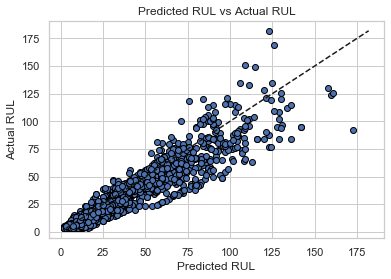

In [227]:
# Residual error in validation data
validation_pred   = [element['rul_prediction'] for element in results.values()]
validation_error  = [element['rul_difference'] for element in results.values()]

y_validation = [element['actual_rul'] for element in results.values()]

# Plot results
fig, ax = plt.subplots()
ax.scatter(validation_pred, y_validation, edgecolors=(0, 0, 0))
ax.plot([min(y_validation), max(y_validation)], [min(y_validation), max(y_validation)], 'k--')
ax.set_xlabel('Predicted RUL')
ax.set_ylabel('Actual RUL')
ax.set_title('Predicted RUL vs Actual RUL')
plt.show()

<br><br><br><br><br><br><br><br><br><br><br><br><br><br>

# Final prediction

In [85]:
%%time

df_train               = load_dataset('../data/DataTrain.txt')
df_train               = df_train.set_index('engine_id')
df_train.loc[: ,'rul'] = get_ruls(df_train)

df_schedule = load_dataset('../data/DataSchedule.txt')
df_schedule = df_schedule.set_index('engine_id')

predictions = final_prediction(df_train, df_schedule)

KeyboardInterrupt: 

In [ ]:
predictions

<br><br><br><br><br><br><br><br><br>

# Old: Validation set

In [19]:
%%time

# Create split
df_training, df_validation = load_add_rul_filter_and_norm_data(percentage_validation_set=0.2)

# Extract random slice of dataframe
# df_validation = extract_part_validation_data(df_validation, create_amount_of_random_numbers = 6, distance_of_max_length = 50)

# Extract slopes
df_slopes = slopes_all_engine(df_training)

# Reduce the dimensionalities to 3 dimensions
df_training_pca, df_validation_pca = perform_pca(df_slopes, df_training, df_validation, keep_rul_in_validation = True)

# Train model to predict Health Indicator
gekke_model = train_health_indictor_model(df_training_pca)

# Add health indicator
df_training_pca['hi_pred']   = gekke_model.predict(df_training_pca[['pca1', 'pca2', 'pca3']])
df_validation_pca['hi_pred'] = gekke_model.predict(df_validation_pca[['pca1', 'pca2', 'pca3']])

Wall time: 259 ms


In [20]:
%%time
# Add exp model
df_training_with_hi_and_exp = add_exponential_fits(df_training_pca)

Wall time: 1min 39s


In [21]:
%%time

total_rul_diff = 0

for engineid in df_validation_pca.index.unique():
    rul_difference = find_for_engineid_lowest_loss(df_training_with_hi_and_exp, 
                                                   df_validation_pca[df_validation_pca.index == engineid])
    print('\n\n\nEngine id {} rul difference: {}.\n\n\n'.format(engineid, rul_difference))
    
    
    total_rul_diff += rul_difference
    
total_rul_diff

Best loss:       inf
Train RUL:       14
Test RUL:        1
RUL difference:  13.56544729613006





Engine id 5 rul difference: 13.56544729613006.



Best loss:       inf
Train RUL:       13
Test RUL:        1
RUL difference:  12.088934918717218





Engine id 7 rul difference: 12.088934918717218.



Best loss:       inf
Train RUL:       20
Test RUL:        1
RUL difference:  19.374095857036828





Engine id 10 rul difference: 19.374095857036828.



Best loss:       1.3979587747797342
Train RUL:       7
Test RUL:        1
RUL difference:  6.7775423082784325





Engine id 14 rul difference: 6.7775423082784325.



Best loss:       inf
Train RUL:       1
Test RUL:        1
RUL difference:  0.9999999999999996





Engine id 16 rul difference: 0.9999999999999996.



Best loss:       inf
Train RUL:       4
Test RUL:        1
RUL difference:  3.90970703294452





Engine id 25 rul difference: 3.90970703294452.



Best loss:       2.946788379040118
Train RUL:       12
Test RUL:        1
RUL 

141.59211006596712